In [37]:
#pspnet18 dropout 03 mean global
import tensorflow as tf
from glob import glob
import pspnet18
import matplotlib.pyplot as plt
import numpy as np

#import Augmentor
print('Tensorflow', tf.__version__)

Tensorflow 2.3.0


In [ ]:
!pip install keras-resnet

  Created wheel for keras-resnet: filename=keras_resnet-0.2.0-py2.py3-none-any.whl size=20487 sha256=e98dfb9599d5425fddb8a589034aef4640e428bc85d3b560222d93af1fc946e8
  Stored in directory: /root/.cache/pip/wheels/5f/09/a5/497a30fd9ad9964e98a1254d1e164bcd1b8a5eda36197ecb3c
Successfully built keras-resnet


In [2]:
!unzip mentah.zip

Streaming output truncated to the last 5000 lines.
  inflating: mentah/trainasli/plastic12.jpg  
  inflating: __MACOSX/mentah/trainasli/._plastic12.jpg  
  inflating: mentah/trainasli/cardboard17.jpg  
  inflating: __MACOSX/mentah/trainasli/._cardboard17.jpg  
  inflating: mentah/trainasli/metal153.jpg  
  inflating: __MACOSX/mentah/trainasli/._metal153.jpg  
  inflating: mentah/trainasli/paper344.jpg  
  inflating: __MACOSX/mentah/trainasli/._paper344.jpg  
  inflating: mentah/trainasli/paper378.jpg  
  inflating: __MACOSX/mentah/trainasli/._paper378.jpg  
  inflating: mentah/trainasli/metal184.jpg  
  inflating: __MACOSX/mentah/trainasli/._metal184.jpg  
  inflating: mentah/trainasli/paper393.jpg  
  inflating: __MACOSX/mentah/trainasli/._paper393.jpg  
  inflating: mentah/trainasli/cardboard121.jpg  
  inflating: __MACOSX/mentah/trainasli/._cardboard121.jpg  
  inflating: mentah/trainasli/glass329.jpg  
  inflating: __MACOSX/mentah/trainasli/._glass329.jpg  
  inflating: mentah/trai

In [38]:
image_list = sorted(glob('mentah/trainglobal/*'))
mask_list = sorted(glob('mentah/trainannot/*'))
print('Found {} images \nFound {} masks'.format(len(image_list), len(mask_list)))

Found 1759 images 
Found 1759 masks


In [4]:
def imshow(img, mask):
    img = tf.io.read_file(img)
    img = tf.image.decode_image(img, channels=3)
    fig = plt.figure(figsize=(20,15))
    ax = fig.add_subplot(1,2,1)
    ax.set_title('Image')
    ax.axis('off')
    ax.imshow(img)
    
    mask = tf.io.read_file(mask)
    mask = tf.image.decode_image(mask, channels=1)
    ax = fig.add_subplot(1,2,2)
    ax.set_title('Mask')
    ax.axis('off')
    ax.imshow(np.squeeze(mask))

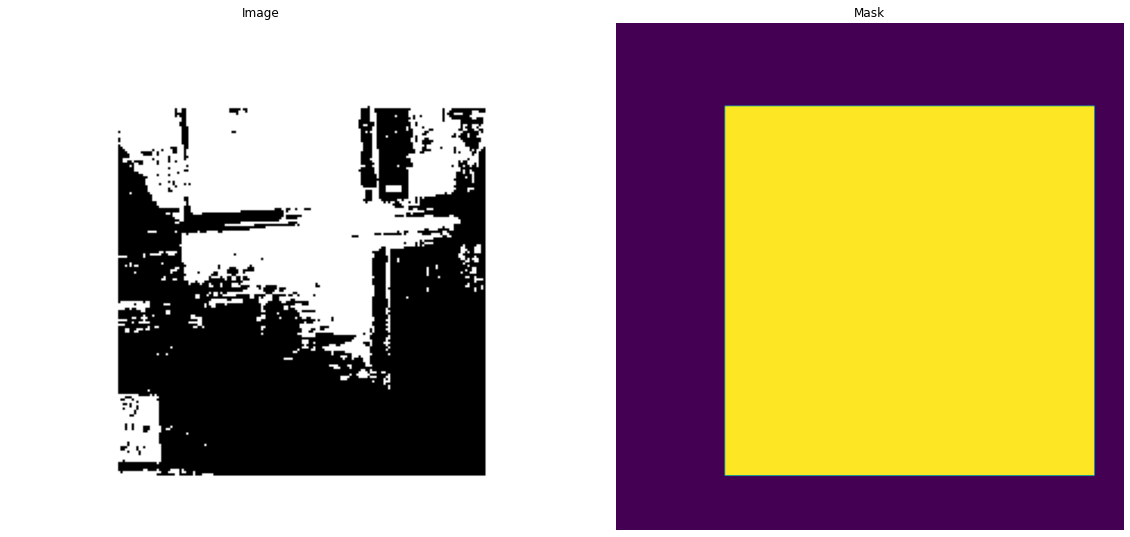

In [39]:
imshow(image_list[10], mask_list[10])

In [6]:
H, W = 224, 224
batch_size = 10
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [40]:
aug = sorted(glob('mentah/trainglobal/*'))

In [26]:
def get_image(path, mask=False):
    img = tf.io.read_file(path)
    if not mask:
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, size=[H, W])
        img /= 255.
    else:
        img = tf.image.decode_png(img, channels=1)
        img = tf.image.resize(img, size=[H, W]) > 0
        img = tf.cast(img, tf.float32)
    return img

def load_data(image_path, mask_path):
    return get_image(image_path), get_image(mask_path, mask=True)

In [41]:
train_ds = tf.data.Dataset.from_tensor_slices((aug, mask_list))
train_ds = train_ds.shuffle(256)
train_ds = train_ds.map(load_data, num_parallel_calls=AUTOTUNE)
train_ds = train_ds.batch(batch_size)
train_ds = train_ds.repeat()
train_ds = train_ds.prefetch(AUTOTUNE)

In [42]:
print(train_ds)

<PrefetchDataset shapes: ((None, 224, 224, 3), (None, 224, 224, 1)), types: (tf.float32, tf.float32)>


In [29]:
def dice_loss(pred, actual):
    num = 2 * tf.reduce_sum((pred * actual), axis=-1)
    den = tf.reduce_sum((pred + actual), axis=-1)
    return 1 - (num + 1) / (den + 1)

In [43]:
model = pspnet18.pspnet50(1, (224, 224, 3), 0.0001)
model.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_58 (Conv2D)              (None, 112, 112, 64) 1792        input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_48 (BatchNo (None, 112, 112, 64) 256         conv2d_58[0][0]                  
__________________________________________________________________________________________________
activation_42 (Activation)      (None, 112, 112, 64) 0           batch_normalization_48[0][0]     
_______________________________________________________________________________________

In [44]:
test_list = sorted(glob('mentah/valglobal/*'))
mask_test = sorted(glob('mentah/valannot/*'))
print('Found {} images \nFound {} masks'.format(len(test_list), len(mask_test)))

Found 384 images 
Found 384 masks


In [45]:
test_ds = tf.data.Dataset.from_tensor_slices((test_list, mask_test))
test_ds = test_ds.shuffle(256)
test_ds = test_ds.map(load_data, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(batch_size)
test_ds = test_ds.repeat()
test_ds = test_ds.prefetch(AUTOTUNE)

print(test_ds)

<PrefetchDataset shapes: ((None, 224, 224, 3), (None, 224, 224, 1)), types: (tf.float32, tf.float32)>


In [46]:
history = model.fit(train_ds, epochs=35, steps_per_epoch=len(image_list)//batch_size, validation_data=test_ds, validation_steps=len(test_list)//batch_size)

Epoch 1/35
175/175 [==============================] - 49s 277ms/step - loss: 0.2292 - dice_coef: 0.5248 - val_loss: 0.2174 - val_dice_coef: 0.5174
Epoch 2/35
175/175 [==============================] - 47s 267ms/step - loss: 0.1519 - dice_coef: 0.6839 - val_loss: 0.1170 - val_dice_coef: 0.7535
Epoch 3/35
175/175 [==============================] - 47s 270ms/step - loss: 0.0917 - dice_coef: 0.8033 - val_loss: 0.0800 - val_dice_coef: 0.8351
Epoch 4/35
175/175 [==============================] - 47s 269ms/step - loss: 0.0663 - dice_coef: 0.8500 - val_loss: 0.1869 - val_dice_coef: 0.6974
Epoch 5/35
175/175 [==============================] - 47s 269ms/step - loss: 0.0549 - dice_coef: 0.8729 - val_loss: 0.0603 - val_dice_coef: 0.8601
Epoch 6/35
175/175 [==============================] - 47s 268ms/step - loss: 0.0489 - dice_coef: 0.8840 - val_loss: 0.2125 - val_dice_coef: 0.6663
Epoch 7/35
175/175 [==============================] - 47s 268ms/step - loss: 0.0468 - dice_coef: 0.8887 - val_loss: 0.

In [ ]:
model.save_weights('weightsasli5003.h5')

dict_keys(['loss', 'dice_coef', 'val_loss', 'val_dice_coef'])


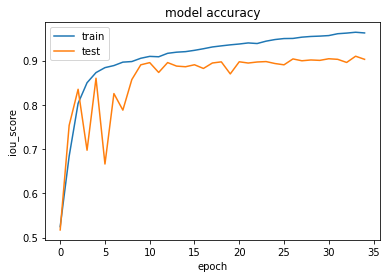

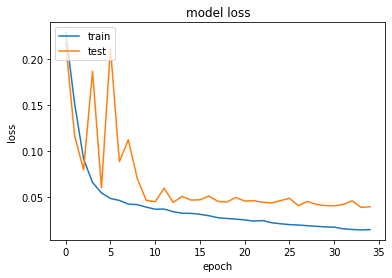

In [47]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['dice_coef'])
plt.plot(history.history['val_dice_coef'])
plt.title('model accuracy')
plt.ylabel('iou_score')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# model = tf.keras.models.load_model('unet_1.h5')
# model.load_weights('weights.h5')

H, W = 224, 224

def get_image(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, size=[H, W])
    img /= 255.
    return img[None, ...]

In [48]:
imagesorted = sorted(glob('mentah/testglobal/*'))
annot = sorted(glob('mentah/testannot/*'))

test_ds1 = tf.data.Dataset.from_tensor_slices((imagesorted, annot))
test_ds1 = test_ds1.shuffle(256)
test_ds1 = test_ds1.map(load_data, num_parallel_calls=AUTOTUNE)
test_ds1 = test_ds1.batch(batch_size)
test_ds1 = test_ds1.repeat()
test_ds1 = test_ds1.prefetch(AUTOTUNE)

In [49]:
model.evaluate(test_ds1, steps=175)

175/175 [==============================] - 14s 80ms/step - loss: 0.0370 - dice_coef: 0.9026


[0.03696880489587784, 0.902604877948761]

AttributeError: ignored

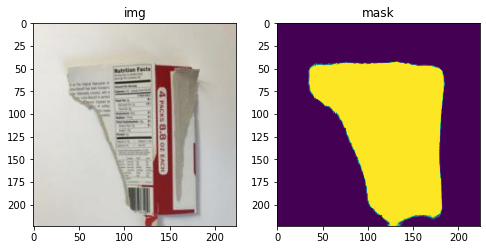

In [ ]:
plot_predictions(271)

In [ ]:
model.save('pspnet_5003.h5')

In [ ]:
import Augmentor

p = Augmentor.Pipeline("./preprocessed2/train/")
# Point to a directory containing ground truth data.
# Images with the same file names will be added as ground truth data
# and augmented in parallel to the original data.
p.ground_truth("./preprocessed2/trainannot")
# Add operations to the pipeline as normal:
p.rotate(probability=1, max_left_rotation=5, max_right_rotation=5)
p.flip_left_right(probability=0.5)
p.zoom_random(probability=0.5, percentage_area=0.8)
p.flip_top_bottom(probability=0.5)
p.sample(50)

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x7F101EE42BE0>:   8%|▊         | 4/50 [00:00<00:06,  7.29 Samples/s]

Initialised with 2143 image(s) found.
Output directory set to ./preprocessed2/train/output.0 ground truth image(s) found.


Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x7F101EE74A90>: 100%|██████████| 50/50 [00:00<00:00, 68.61 Samples/s]
